<a href="https://colab.research.google.com/github/Huypham07/AutoDocs/blob/main/classification/Classify_using_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("huypham71/esgify_vn_class_weights")
model = AutoModelForSequenceClassification.from_pretrained("huypham71/esgify_vn_class_weights")


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
data_zip = "all_banks_preprocessed_sentences.zip"

In [5]:
# unzip
!unzip {data_zip}

Archive:  all_banks_preprocessed_sentences.zip
replace all_banks_preprocessed_sentences.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: all_banks_preprocessed_sentences.csv  


In [7]:
# Load and filter data
print("Loading data...")
df = pd.read_csv("all_banks_preprocessed_sentences.csv")
print(f"Total sentences: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head(3)

Loading data...
Total sentences: 130,359
Columns: ['bank', 'year', 'report_type', 'sentence_id', 'original_sentence', 'tokenized_sentence', 'cleaned_sentence', 'word_count', 'char_count']

Sample data:


,bank,year,report_type,sentence_id,original_sentence,tokenized_sentence,cleaned_sentence,word_count,char_count
0,agribank,2015,bctn,0,PB BÁO CÁO THƯỜNG NIÊN AGRIBANK 2015 MỤC LỤC T...,PB BÁO_CÁO THƯỜNG_NIÊN AGRIBANK 2015 MỤC_LỤC T...,pb báo_cáo thường_niên agribank 2015 mục_lục t...,9,63
1,agribank,2015,bctn,1,Thông điệp của Chủ tịch Hội đồng Thành viên AG...,Thông_điệp của Chủ_tịch Hội_đồng Thành_viên AG...,thông_điệp của chủ_tịch hội_đồng thành_viên ag...,11,86
2,agribank,2015,bctn,4,Quá trình hình thành và phát triển 16.,Quá_trình hình_thành và phát_triển 16 .,quá_trình hình_thành và phát_triển 16,5,37


In [8]:
SELECTED_BANK = "vietcombank"
SELECTED_YEAR = 2024
SAMPLE_SIZE = 5000
RANDOM_SEED = 42

In [45]:
# Filter by bank and year
df_filtered = df[
    (df['bank'] == SELECTED_BANK) &
    (df['year'] == SELECTED_YEAR)
].copy()

print(f"Filtered sentences: {len(df_filtered):,}")

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f"\nData prepared: {len(df_filtered):,} sentences")

Filtered sentences: 777

Data prepared: 777 sentences


In [37]:
df_filtered = df_filtered[['bank', 'year', 'report_type', 'sentence_id', 'original_sentence' ]]

In [38]:
import torch
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

id2label = model.config.id2label


def predict_with_model(text, model, tokenizer, id2label):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=256, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()

    return {
        'predicted_label': id2label[predicted_class],
        'confidence': confidence
    }


predict original_sentences

In [39]:
predicted_labels = []
confidences = []

for text in tqdm(df_filtered['original_sentence'], desc="Classifying"):
    result = predict_with_model(text, model, tokenizer, id2label)
    predicted_labels.append(result['predicted_label'])
    confidences.append(result['confidence'])

df_filtered['predicted_label'] = predicted_labels
df_filtered['confidence'] = confidences

Classifying: 100%|██████████| 777/777 [00:10<00:00, 72.16it/s]


In [41]:
df_filtered.head(10)

,bank,year,report_type,sentence_id,original_sentence,predicted_label,confidence
0,vietcombank,2024,bctn,0,| MỤC LỤC | Thông tin chung | 04 | Báo cáo của...,Social Performance - Community & Other,0.478349
1,vietcombank,2024,bctn,1,"Tăng trưởng kinh tế có cải thiện, nhưng sự phâ...",Not Relevant to ESG,0.381039
2,vietcombank,2024,bctn,2,Trong khi các nền kinh tế phát triển thu hút d...,Not Relevant to ESG,0.451429
3,vietcombank,2024,bctn,3,"Các cuộc xung đột quân sự kéo dài, như Nga – U...",Supply Chain Risk,0.983275
4,vietcombank,2024,bctn,4,"Thị trường Chứng khoán Việt Nam, trước những t...",Not Relevant to ESG,0.958544
5,vietcombank,2024,bctn,5,Mặc dù có khởi đầu tương đối thuận lợi và tích...,Not Relevant to ESG,0.920063
6,vietcombank,2024,bctn,6,Mặc dù phải đối mặt với những diễn biến phức t...,Not Relevant to ESG,0.775978
7,vietcombank,2024,bctn,7,"Tổng doanh thu của Công ty đạt 1.519,7 tỷ đồng...",Not Relevant to ESG,0.834508
8,vietcombank,2024,bctn,8,"Về thị phần kinh doanh, năm 2025, VCBS lọt top...",Not Relevant to ESG,0.950458
9,vietcombank,2024,bctn,9,"Bên cạnh đó, đối với công tác phát triển và mở...",Strategy & Policy,0.862320


### 1. Phân phối các nhãn được dự đoán

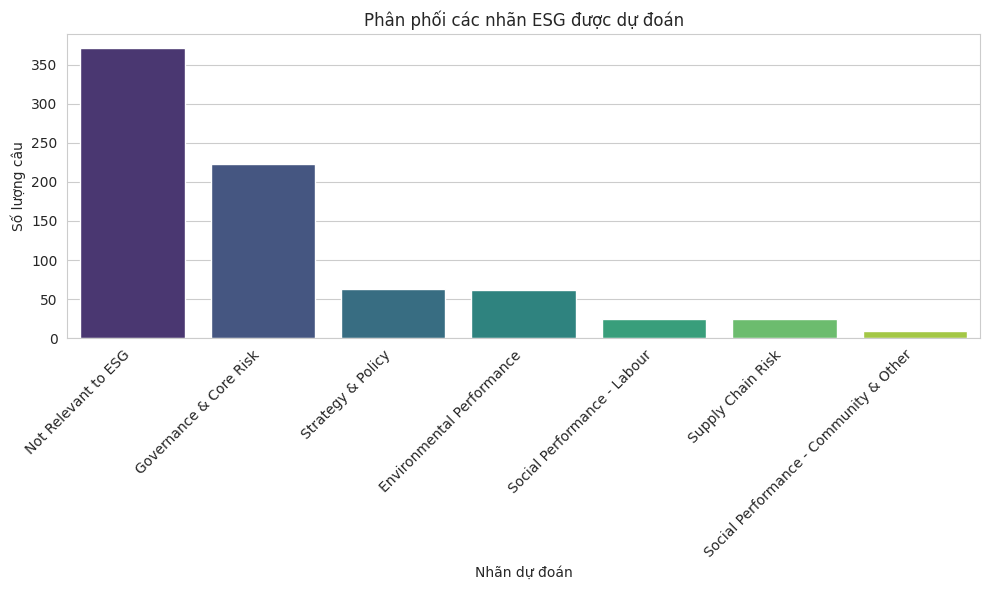

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the distribution of predicted labels
label_distribution = df_filtered['predicted_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='viridis')
plt.title('Phân phối các nhãn ESG được dự đoán')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Số lượng câu')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2. Thống kê độ tin cậy cho từng nhãn

In [43]:
# Calculate confidence statistics per predicted label
confidence_stats = df_filtered.groupby('predicted_label')['confidence'].agg(['mean', 'min', 'max', 'std'])
print("Thống kê độ tin cậy theo nhãn:")
display(confidence_stats.sort_values(by='mean', ascending=False))

Thống kê độ tin cậy theo nhãn:


,mean,min,max,std
predicted_label,,,,
Supply Chain Risk,0.788207,0.440912,0.983275,0.164541
Not Relevant to ESG,0.777072,0.313190,0.978505,0.174452
Governance & Core Risk,0.762555,0.322388,0.985341,0.182825
Strategy & Policy,0.755758,0.286584,0.976294,0.185865
Social Performance - Labour,0.693263,0.333753,0.985391,0.231337
Environmental Performance,0.615800,0.327618,0.929659,0.152489
Social Performance - Community & Other,0.510171,0.342200,0.951488,0.180518


### 3. Các câu với độ tin cậy cao và thấp nhất

In [44]:
print("Top 5 câu với độ tin cậy cao nhất:")
display(df_filtered.sort_values(by='confidence', ascending=False).head(5)[['original_sentence', 'predicted_label', 'confidence']])

print("\nTop 5 câu với độ tin cậy thấp nhất:")
display(df_filtered.sort_values(by='confidence', ascending=True).head(5)[['original_sentence', 'predicted_label', 'confidence']])

Top 5 câu với độ tin cậy cao nhất:


,original_sentence,predicted_label,confidence
465,Trợ cấp nghỉ hưu Nhân viên Công ty khi nghỉ hư...,Social Performance - Labour,0.985391
318,"Qua hoạt động kiểm soát, Ban Kiểm soát đã kịp ...",Governance & Core Risk,0.985341
147,Các hoạt động chính bao gồm: Quản lý rủi ro ho...,Governance & Core Risk,0.984598
360,"Khi thực hiện đánh giá các rủi ro này, kiểm to...",Governance & Core Risk,0.983701
3,"Các cuộc xung đột quân sự kéo dài, như Nga – U...",Supply Chain Risk,0.983275



Top 5 câu với độ tin cậy thấp nhất:


,original_sentence,predicted_label,confidence
43,Nhận bằng khen của Thủ tướng Chính phủ về thàn...,Strategy & Policy,0.286584
44,Nhận bằng khen của Chủ tịch Ủy ban Nhân dân (U...,Not Relevant to ESG,0.313190
80,Thành lập Phòng giao dịch Giảng Võ và Văn phòn...,Governance & Core Risk,0.322388
128,Thực hiện tư vấn hồ sơ chào bán và làm đại lý ...,Environmental Performance,0.327618
409,Tăng hoặc giảm số dư tài khoản dự phòng được g...,Social Performance - Labour,0.333753


In [46]:
df_filtered.to_csv("vcb_2024_classify.csv")